In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from ddpm.pipeline import DDPMPipeline
from ddpm.diffusion import GaussianDiffusion
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms.v2 as v2
import ddpm.utils as utils
from ddpm.unet import UNet

# Training DDPMs on Fashion MNIST
We train an DDPM on the Fashion MNIST dataset for `50` epochs, using the Adam optimizer with a learning rate of `3e-4`. The U-Net has a model channel of `64`, `4` downsampling blocks, and `2` resnet blocks. We apply self-attention at the 2x downsampling block. There are corresponding skip connections at the respective upsampling and downsampling blocks.

We use a linear noise schedule with $\beta_1=0.0001$ and $\beta_T=0.02$ with timesteps $T=100$.

Loading the DDPM pipeline.

In [17]:
pipe = DDPMPipeline.from_checkpoint("../fashionmnist1/").to("cuda")

Load U-Net and initialize `GaussianDiffusion` object

In [18]:
beta_start = 1e-4
beta_end = 0.02
timesteps = 1000
diffusion = GaussianDiffusion(
    beta_start=beta_start,
    beta_end=beta_end,
    timesteps=timesteps
).to("cuda")

In [19]:
unet = UNet.from_checkpoint("../fashionmnist1/").to("cuda")

Load FashionMNIST Dataset

In [20]:
convert_image_to_tensor = v2.Compose([
    v2.ToTensor(),
    v2.Resize((32, 32))
])

convert_tensor_to_image = v2.ToPILImage(mode="L")

In [21]:
dataset = FashionMNIST(root="../data", download=True, train=False)
image = dataset[0][0]

batch = convert_image_to_tensor(image).unsqueeze(0).to("cuda")
batch.shape

torch.Size([1, 1, 32, 32])

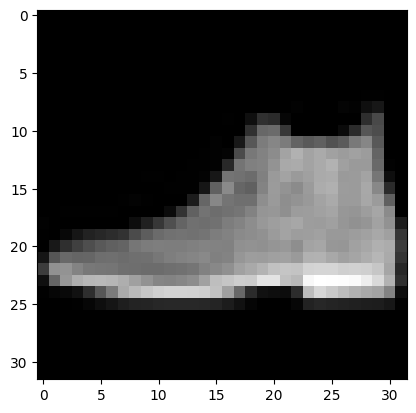

In [22]:
plt.imshow(convert_tensor_to_image(batch.squeeze(0)), cmap="gray")

## Forward Diffusion
We add gaussian noise according to a noise schedule for `T` timesteps. The image looks progressively more like random noise.

In [23]:
num_noise_timesteps = 5

noise_timesteps = torch.linspace(0, timesteps, num_noise_timesteps + 1).to("cuda").int()[1:] - 1
noise = torch.randn((num_noise_timesteps, 1, 32, 32)).to("cuda")

samples = batch.repeat(num_noise_timesteps, 1, 1, 1)
noised_samples = diffusion.q_sample(samples, noise_timesteps, noise)
noised_samples_images = [convert_tensor_to_image(sample) for sample in noised_samples]
noised_samples_grid = utils.make_image_grid([convert_tensor_to_image(batch.squeeze(0)), *noised_samples_images], rows=1, cols=num_noise_timesteps + 1)

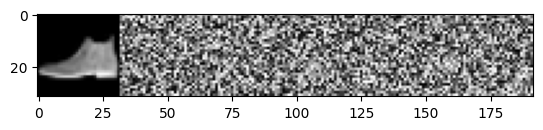

In [24]:
plt.imshow(noised_samples_grid, cmap="gray")

## Reverse Diffusion
We iteratively remove noise for `T` timesteps to get the denoised sample. 

In [26]:
denoised_samples_output = diffusion.p_sample(unet, noised_samples, noise_timesteps)
denoised_samples_images = [convert_tensor_to_image(sample) for sample in denoised_samples_output.prev_sample]
noised_samples_grid = utils.make_image_grid([convert_tensor_to_image(batch.squeeze(0)), *denoised_samples_images], rows=1, cols=num_noise_timesteps + 1)

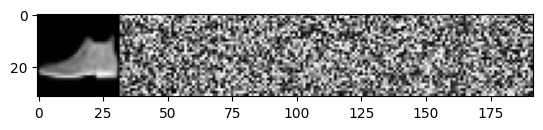

In [27]:
plt.imshow(noised_samples_grid, cmap="gray")

## Unconditioned Generation
We show unconditional Fashion MNIST generations

In [30]:
output = pipe(
    num_images=1,
    image_size=32,
    output_samples=True
)

100%|██████████| 1000/1000 [00:19<00:00, 50.60it/s]


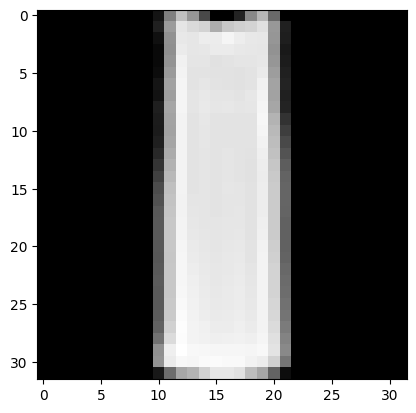

In [31]:
plt.imshow(output.images[0], cmap="gray")

## Predicting `x_0` from Noise
The U-Net receives `x_t` and `t` and predicts the noise added to `x_0` to get to `x_t`. After reparameterization, we find that predicting noise is equivalent to predicting `x_0`. Here, we show the predicted `x_0` for `x_t` at different timesteps.

In [32]:
pred_x0_images = [convert_tensor_to_image(sample) for sample in denoised_samples_output.pred_x0]
noised_samples_grid = utils.make_image_grid([convert_tensor_to_image(batch.squeeze(0)), *pred_x0_images], rows=1, cols=num_noise_timesteps + 1)

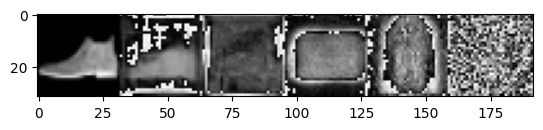

In [33]:
plt.imshow(noised_samples_grid, cmap="gray")